In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other* (self.data **(other - 1)) * out.grad   
    out._backward = _backward
    return out
    
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other):
    return self * other**-1
  def __neg__(self):
    return self *-1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):    # self + other
    return self + other


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    return out

  def backward(self) :
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [3]:
b = Value(2.0); b =  Value(2.0)
c = b+b
c.grad

0.0

In [4]:
a = Value(2.0, label='a')
b = -a; b.label='b'
b.backward()
b.grad

1.0

In [ ]:
# !pip install graphviz

In [ ]:
from graphviz import Digraph

In [6]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

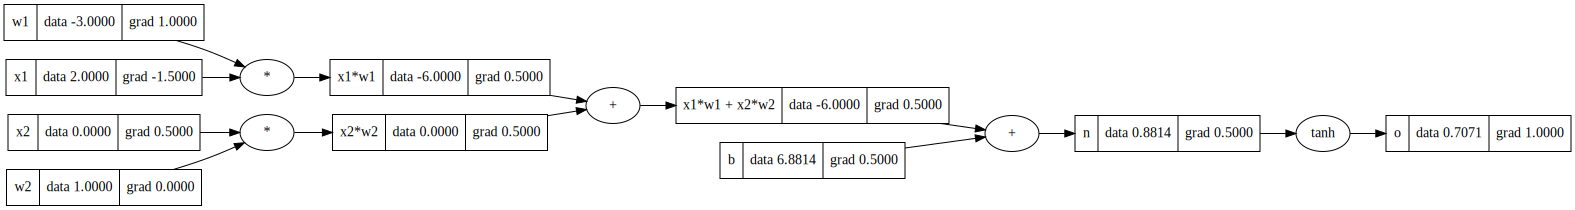

In [11]:
draw_dot(o)

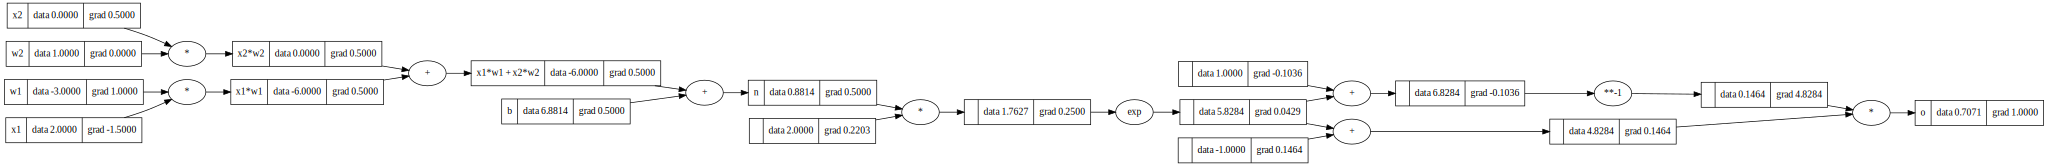

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [13]:
import torch

In [14]:
x1 = torch.Tensor([2.0]).double()                        ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                        ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                       ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                        ;w2.requires_grad = True
b = torch.Tensor([1.0]).double()                         ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

-0.9999092042625951
------
x2 0.0001815832309438603
w2 0.0
x1 -0.0005447496928315809
w1 0.0003631664618877206


In [15]:
import random

In [16]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [17]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9012348630371708)

In [18]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9012348630371708),
 Value(data=-0.3344895303946296),
 Value(data=-0.9462753546664359),
 Value(data=-0.9468535059897694)]

In [19]:
loss = sum((yout - ygt) **2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.236029096455235)

In [20]:
for k in range(100):
    # update

    
    # forward pass
    loss
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
       p.grad =0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 4.236029096455235
1 3.8570610156944665
2 3.7557119143247037
3 3.5725219350309363
4 3.1137859689764356
5 1.8336754594732634
6 0.8322115999354138
7 0.4647630141367825
8 0.23558898663088504
9 0.1615629349422149
10 0.12229248492690142
11 0.09731724902489655
12 0.08025599578099199
13 0.06796188751461839
14 0.05873285360300454
15 0.051578067803446995
16 0.045885770513415636
17 0.04125973320419119
18 0.03743298001425366
19 0.03421956877466138
20 0.03148630364013286
21 0.02913544154833656
22 0.027093738037104458
23 0.025305291594264073
24 0.023726741581748152
25 0.02232396800250253
26 0.021069774924410836
27 0.01994223331742774
28 0.018923475253530022
29 0.017998802924382218
30 0.01715602101244997
31 0.016384930001814547
32 0.01567693711204394
33 0.015024754323046317
34 0.0144221616615696
35 0.013863819935897012
36 0.013345121323295073
37 0.012862069211336653
38 0.012411180849202869
39 0.011989407932549597
40 0.011594071397837403
41 0.011222807557594288
42 0.010873523349262993
43 0.010544358

In [21]:
ypred

[Value(data=0.9575306053313856),
 Value(data=-0.9634146023522566),
 Value(data=-0.9801314507174191),
 Value(data=0.9547952734704191)]